In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier    #Please install catboost (!pip install catboost)  
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [49]:
german = pd.read_csv("C:/Users/matages/Desktop/German_Credit/german_clean.csv")

In [50]:
german = german.iloc[:,1:]

In [51]:
german.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Class
0,... < 0 DM,6,critical account/other credits existing (not a...,radio/television,1169,unknown/ no savings account,.. >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,Good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account/other credits existing (not a...,education,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,... < 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad


In [52]:
german['Class'] = german['Class'].apply(lambda x: 0 if x =='Good' else 1)

In [53]:
german['Class'].value_counts()

Class
0    700
1    300
Name: count, dtype: int64

In [54]:
cat_col = [i for i in german.columns if type(german[i][0])==str]
num_col = [i for i in german.columns if type(german[i][0])!=str]
cat_col

['Status of existing checking account',
 'Credit history',
 'Purpose',
 'Savings account/bonds',
 'Present employment since',
 'Personal status and sex',
 'Other debtors / guarantors',
 'Property',
 'Other installment plans',
 'Housing',
 'Job',
 'Telephone',
 'foreign worker']

In [55]:
X = german[[i for i in german.columns if i!='Class']]
y = german['Class']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1990)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(670, 20)
(330, 20)
(670,)
(330,)


In [58]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.7219827586206896, 1: 1.6262135922330097}

In [59]:
# Convert categorical columns to category type
X_train[cat_col] = X_train[cat_col].astype('category')
X_test[cat_col] = X_test[cat_col].astype('category')

In [60]:
y_train = y_train.astype('category')
y_test = y_test.astype('category')

## XGB

In [61]:
hyper_parameter = {
    'max_depth': [3, 5, 7],
    'eta': [0.1, 0.3, 0.5,0.7,0.9],
    'subsample': [0.5, 0.7, 1]
}

In [71]:
### XGB
Hyperparameter_tune = {
    'max_depth': [],
    'eta': [],
    'subsample': [],
    'f1_score':[]
}
for i in hyper_parameter['max_depth']:
    for j in hyper_parameter['eta']:
        for k in hyper_parameter['subsample']:
            model = XGBClassifier(enable_categorical=True, max_depth=i, eta=j,subsample=k)
            model.fit(X_train, y_train)
            #Prediction
            y_pred = model.predict(X_test)
            #Evaluation
            Hyperparameter_tune['max_depth'].append(i)
            Hyperparameter_tune['eta'].append(j)
            Hyperparameter_tune['subsample'].append(k)
            Hyperparameter_tune['f1_score'].append(f1_score(y_test, y_pred))

In [72]:
Hyperparameter_Result = pd.DataFrame(Hyperparameter_tune)
Hyperparameter_Result.head()

,max_depth,eta,subsample,f1_score
0,3,0.1,0.5,0.527473
1,3,0.1,0.7,0.526882
2,3,0.1,1.0,0.524590
3,3,0.3,0.5,0.489583
4,3,0.3,0.7,0.527919


In [73]:
Best_parameter = Hyperparameter_Result.sort_values('f1_score',ascending=False).head(1)
Best_parameter

,max_depth,eta,subsample,f1_score
8,3,0.5,1.0,0.571429


In [74]:
max_depth = Best_parameter['max_depth'].values[0]
eta = Best_parameter['eta'].values[0]
subsample = Best_parameter['subsample'].values[0]

In [83]:
model = XGBClassifier(enable_categorical=True, max_depth=max_depth, eta=eta, subsample=subsample)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.5, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [84]:
#Prediction
y_pred = model.predict(X_test)
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       236
           1       0.55      0.60      0.57        94

    accuracy                           0.75       330
   macro avg       0.69      0.70      0.70       330
weighted avg       0.75      0.75      0.75       330



In [86]:
print('AUC score:', roc_auc_score(y_test, y_pred))

AUC score: 0.7004147133068878


Text(0.5, 1.0, 'Feature Importance')

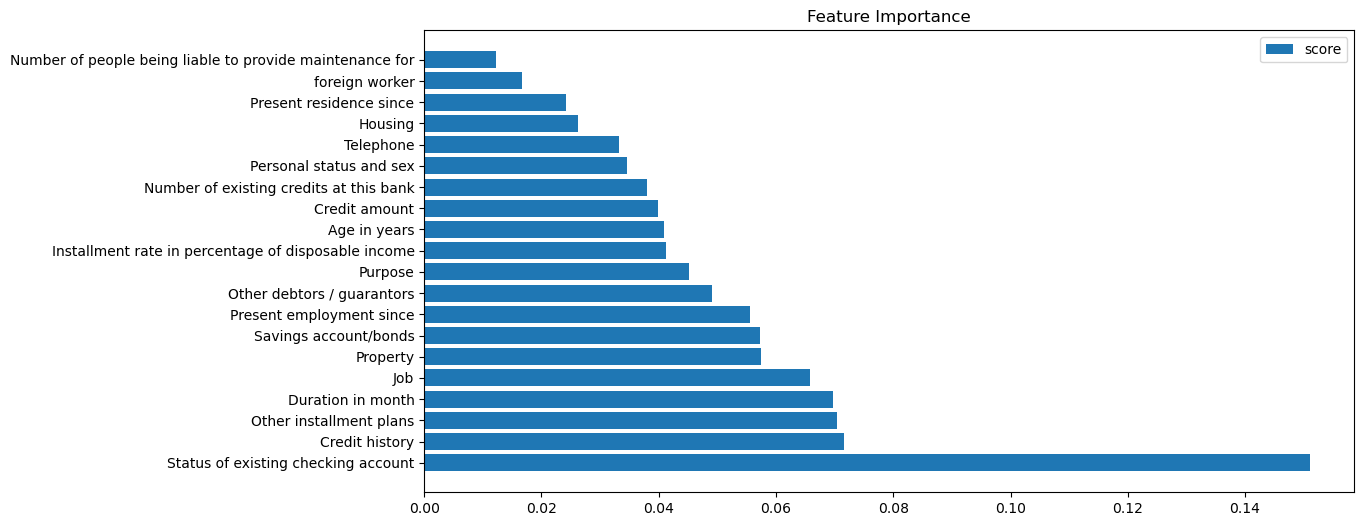

In [85]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(-feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.legend(["score"], loc="upper right")
plt.title('Feature Importance')

# cat boost

In [94]:
hyper_parameter = {
    'learning_rate': [0.1,0.5,0.9],
    'depth': [1,3,5,7],
    'iteration':[250,500,750,1000]
}

In [95]:
### catboost
Hyperparameter_tune = {
    'learning_rate': [],
    'depth': [],
    'iteration': [],
    'f1_score':[]
}
for i in hyper_parameter['learning_rate']:
    for j in hyper_parameter['depth']:
        for k in hyper_parameter['iteration']:
                model_cl = CatBoostClassifier(iterations=k, learning_rate=i, depth=j, 
                            rsm=1, loss_function= 'Logloss', class_weights=class_weights,
                            use_best_model=True, verbose=0,cat_features=cat_col)
                model_cl.fit(X_train, y_train, eval_set=(X_train, y_train))
                #Prediction
                y_pred = model.predict(X_test)
                #Evaluation
                Hyperparameter_tune['learning_rate'].append(i)
                Hyperparameter_tune['depth'].append(j)
                Hyperparameter_tune['iteration'].append(k)
                Hyperparameter_tune['f1_score'].append(f1_score(y_test, y_pred))

In [99]:
Hyperparameter_Result = pd.DataFrame(Hyperparameter_tune)
Hyperparameter_Result.head()

,learning_rate,depth,iteration,f1_score
0,0.1,1,250,0.571429
1,0.1,1,500,0.571429
2,0.1,1,750,0.571429
3,0.1,1,1000,0.571429
4,0.1,3,250,0.571429


In [100]:
Best_parameter = Hyperparameter_Result.sort_values('f1_score',ascending=False).head(1)
Best_parameter

,learning_rate,depth,iteration,f1_score
0,0.1,1,250,0.571429


In [102]:
learning_rate = Best_parameter['learning_rate'].values[0]
depth = Best_parameter['depth'].values[0]
iteration = Best_parameter['iteration'].values[0]

In [103]:
model_cl = CatBoostClassifier(iterations=iteration, learning_rate=learning_rate, depth=depth, 
                            rsm=1, loss_function= 'Logloss', class_weights=class_weights,
                            use_best_model=True, verbose=0,cat_features=cat_col)
model_cl.fit(X_train, y_train, eval_set=(X_train, y_train))

In [106]:
#Prediction
y_pred = model_cl.predict(X_test)
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.63      0.72       236
           1       0.43      0.69      0.53        94

    accuracy                           0.65       330
   macro avg       0.63      0.66      0.62       330
weighted avg       0.72      0.65      0.67       330



In [107]:
print('AUC score:', roc_auc_score(y_test, y_pred))

AUC score: 0.6614226469527588


Text(0.5, 1.0, 'Feature Importance')

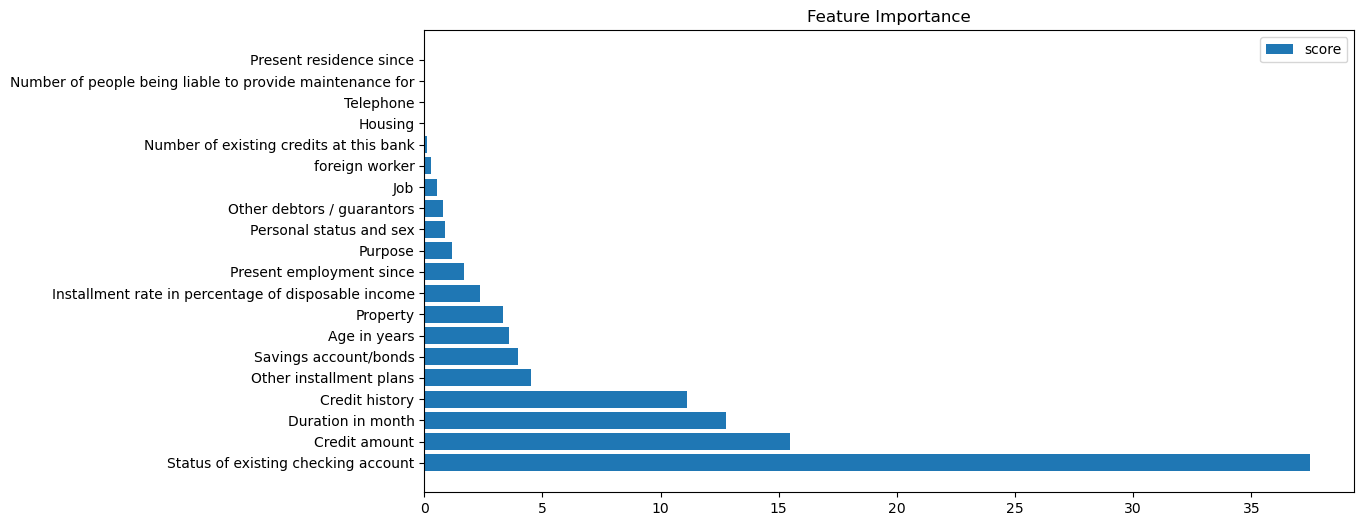

In [108]:
feature_importance = model_cl.feature_importances_
sorted_idx = np.argsort(-feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.legend(["score"], loc="upper right")
plt.title('Feature Importance')